#Imports and Class/Function Definitions

In [8]:
# CELL 1: Imports and Class/Function Definitions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Data Preprocessing and Splitting ---

def load_and_preprocess_data(filepath="titanic.csv"):
    """Loads, cleans, and encodes the Titanic dataset."""
    df = pd.read_csv(filepath)
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

    # Impute missing values
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # Encode categorical features
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

    X = df.drop('Survived', axis=1).values
    y = df['Survived'].values
    return X, y

def train_test_split_manual(X, y, test_size=0.2, random_state=42):
    """Manual implementation of train-test split."""
    np.random.seed(random_state)
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

class StandardScaler:
    """Manual implementation of standard scaler."""
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.std[self.std == 0] = 1
        return self

    def transform(self, X):
        return (X - self.mean) / self.std

# --- PCA Implementation ---

class PCA:
    """Manual implementation of Principal Component Analysis."""
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance_ratio = None
        self.eigenvalues = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        self.eigenvalues = eigenvalues
        
        idx = np.argsort(eigenvalues)[::-1]
        eigenvectors_sorted = eigenvectors[:, idx]
        self.components = eigenvectors_sorted[:, :self.n_components]
        
        sorted_eigenvalues = eigenvalues[idx]
        self.explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)

    def transform(self, X):
        X_centered = X - self.mean
        return X_centered.dot(self.components)

# --- Classification Models (Gradient Descent from Scratch) ---

class LogisticRegression:
    """Logistic Regression implemented using Batch Gradient Descent."""
    def __init__(self, lr=0.01, n_iterations=10000):
        self.lr = lr
        self.n_iterations = n_iterations
        self.weights = None

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        for _ in range(self.n_iterations):
            linear_model = X.dot(self.weights)
            y_predicted = self._sigmoid(linear_model)
            gradient = X.T.dot(y_predicted - y) / n_samples
            self.weights -= self.lr * gradient

    def predict_proba(self, X):
        return self._sigmoid(X.dot(self.weights))

    def predict(self, X):
        return np.where(self.predict_proba(X) >= 0.5, 1, 0)

class LinearSVM:
    """Linear SVM implemented using Batch Gradient Descent (Hinge Loss)."""
    def __init__(self, lr=0.005, n_iterations=10000, C=0.01):
        self.lr = lr
        self.n_iterations = n_iterations
        self.lambda_param = 1 / C
        self.weights = None

    def fit(self, X, y):
        y_svm = np.where(y == 0, -1, 1)
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        for _ in range(self.n_iterations):
            margin = y_svm * X.dot(self.weights)
            reg_gradient = 2 * self.lambda_param * self.weights
            reg_gradient[0] = 0
            misclassified_mask = margin < 1
            hinge_gradient = -X[misclassified_mask].T.dot(y_svm[misclassified_mask]) / n_samples
            total_gradient = reg_gradient + hinge_gradient
            self.weights -= self.lr * total_gradient

    def decision_function(self, X):
        return X.dot(self.weights)

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0, 1, 0)

# --- Evaluation Functions ---

def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def calculate_roc_and_auc(scores, y_true):
    """Calculates ROC curve points (FPR, TPR) and AUC manually."""
    
    thresholds = np.linspace(0, 1, 101) 
    
    # Scale scores to [0, 1] if they are decision function outputs (like SVM)
    min_s, max_s = np.min(scores), np.max(scores)
    if max_s - min_s > 1e-6:
        scores_scaled = (scores - min_s) / (max_s - min_s)
    else:
        return [0.0, 1.0], [0.0, 1.0], 0.5

    y_true = np.array(y_true)
    y_pos = y_true == 1
    y_neg = y_true == 0
    n_pos = np.sum(y_pos)
    n_neg = np.sum(y_neg)
    
    if n_pos == 0 or n_neg == 0:
        return [0.0, 1.0], [0.0, 1.0], 0.5

    fpr_list, tpr_list = [], []
    
    for t in thresholds:
        y_pred = (scores_scaled >= t)
        tp = np.sum(y_pred[y_pos] == 1)
        fp = np.sum(y_pred[y_neg] == 1)
        tpr = tp / n_pos
        fpr = fp / n_neg
        fpr_list.append(fpr)
        tpr_list.append(tpr)

    # AUC calculation using the trapezoidal rule (manual summation)
    fpr_list, tpr_list = np.array(fpr_list), np.array(tpr_list)
    sort_indices = np.argsort(fpr_list)
    fpr_list = fpr_list[sort_indices]
    tpr_list = tpr_list[sort_indices]

    auc = 0
    for i in range(len(fpr_list) - 1):
        auc += 0.5 * (tpr_list[i] + tpr_list[i+1]) * (fpr_list[i+1] - fpr_list[i])
        
    return fpr_list, tpr_list, auc

print("Helper classes and functions defined.")

Helper classes and functions defined.


#Data Loading, Splitting, and Scaling

In [9]:
# CELL 2: Data Loading, Splitting, and Scaling

# Load and split data
X, y = load_and_preprocess_data()
X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2, random_state=42)
print(f"Data split: {X_train.shape[0]} training samples, {X_test.shape[0]} testing samples.")

# Standardize features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features standardized.")

# Add bias term (column of 1s) for non-PCA models
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]
print("Bias term added for non-PCA models.")

Data split: 713 training samples, 178 testing samples.
Features standardized.
Bias term added for non-PCA models.


C:\Users\Asus\AppData\Local\Temp\ipykernel_19120\3994865980.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_19120\3994865980.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

#PCA Implementation and Scree Plot


PCA fitted and data transformed to 4 components.


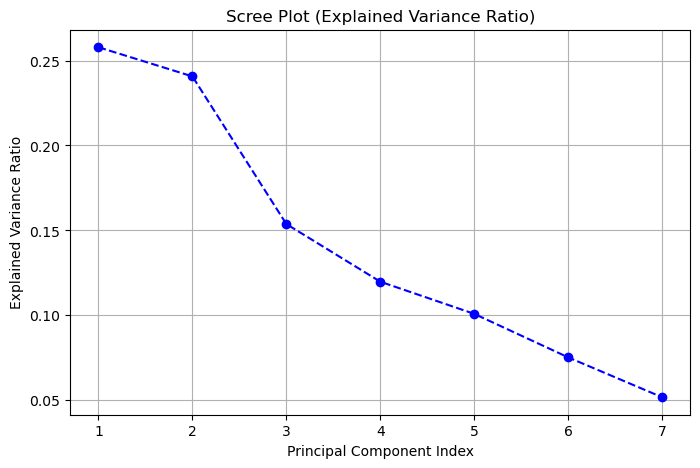

In [10]:
# CELL 3: PCA Implementation and Scree Plot

# Apply PCA (k=4 components selected for retaining good variance)
n_components_pca = 4
pca = PCA(n_components=n_components_pca)
pca.fit(X_train_scaled)

# Transform data
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Add bias term to PCA data
X_train_pca_b = np.c_[np.ones((X_train_pca.shape[0], 1)), X_train_pca]
X_test_pca_b = np.c_[np.ones((X_test_pca.shape[0], 1)), X_test_pca]
print(f"PCA fitted and data transformed to {n_components_pca} components.")

# Generate Scree Plot
explained_variance_ratio_all = pca.explained_variance_ratio
components = np.arange(1, len(explained_variance_ratio_all) + 1)

plt.figure(figsize=(8, 5))
plt.plot(components, explained_variance_ratio_all, marker='o', linestyle='--', color='b')
plt.title('Scree Plot (Explained Variance Ratio)')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.xticks(components)
plt.show()

#Model Training and Evaluation

In [11]:
# CELL 4: Model Training and Evaluation

results = {}
roc_data = {}

# --- 1. No PCA ---
print("--- Training Models on Original Scaled Data ---")
lr_npca = LogisticRegression()
lr_npca.fit(X_train_b, y_train)
scores_lr_npca = lr_npca.predict_proba(X_test_b)
fpr_lr_npca, tpr_lr_npca, auc_lr_npca = calculate_roc_and_auc(scores_lr_npca, y_test)
results['LR_NoPCA'] = calculate_accuracy(y_test, lr_npca.predict(X_test_b))
results['LR_NoPCA_AUC'] = auc_lr_npca
roc_data['LR_NoPCA'] = (fpr_lr_npca, tpr_lr_npca)
print(f"LR_NoPCA: Accuracy={results['LR_NoPCA']:.4f}, AUC={auc_lr_npca:.4f}")

svm_npca = LinearSVM()
svm_npca.fit(X_train_b, y_train)
scores_svm_npca = svm_npca.decision_function(X_test_b)
fpr_svm_npca, tpr_svm_npca, auc_svm_npca = calculate_roc_and_auc(scores_svm_npca, y_test)
results['SVM_NoPCA'] = calculate_accuracy(y_test, svm_npca.predict(X_test_b))
results['SVM_NoPCA_AUC'] = auc_svm_npca
roc_data['SVM_NoPCA'] = (fpr_svm_npca, tpr_svm_npca)
print(f"SVM_NoPCA: Accuracy={results['SVM_NoPCA']:.4f}, AUC={auc_svm_npca:.4f}")


# --- 2. With PCA (k=4) ---
print("\n--- Training Models on PCA Transformed Data (k=4) ---")
lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca_b, y_train)
scores_lr_pca = lr_pca.predict_proba(X_test_pca_b)
fpr_lr_pca, tpr_lr_pca, auc_lr_pca = calculate_roc_and_auc(scores_lr_pca, y_test)
results['LR_PCA'] = calculate_accuracy(y_test, lr_pca.predict(X_test_pca_b))
results['LR_PCA_AUC'] = auc_lr_pca
roc_data['LR_PCA'] = (fpr_lr_pca, tpr_lr_pca)
print(f"LR_PCA: Accuracy={results['LR_PCA']:.4f}, AUC={auc_lr_pca:.4f}")

svm_pca = LinearSVM()
svm_pca.fit(X_train_pca_b, y_train)
scores_svm_pca = svm_pca.decision_function(X_test_pca_b)
fpr_svm_pca, tpr_svm_pca, auc_svm_pca = calculate_roc_and_auc(scores_svm_pca, y_test)
results['SVM_PCA'] = calculate_accuracy(y_test, svm_pca.predict(X_test_pca_b))
results['SVM_PCA_AUC'] = auc_svm_pca
roc_data['SVM_PCA'] = (fpr_svm_pca, tpr_svm_pca)
print(f"SVM_PCA: Accuracy={results['SVM_PCA']:.4f}, AUC={auc_svm_pca:.4f}")

--- Training Models on Original Scaled Data ---
LR_NoPCA: Accuracy=0.7978, AUC=0.8776
SVM_NoPCA: Accuracy=0.5899, AUC=0.8507

--- Training Models on PCA Transformed Data (k=4) ---
LR_PCA: Accuracy=0.7865, AUC=0.8523
SVM_PCA: Accuracy=0.5899, AUC=0.8424


#Final Visualizations and Summary

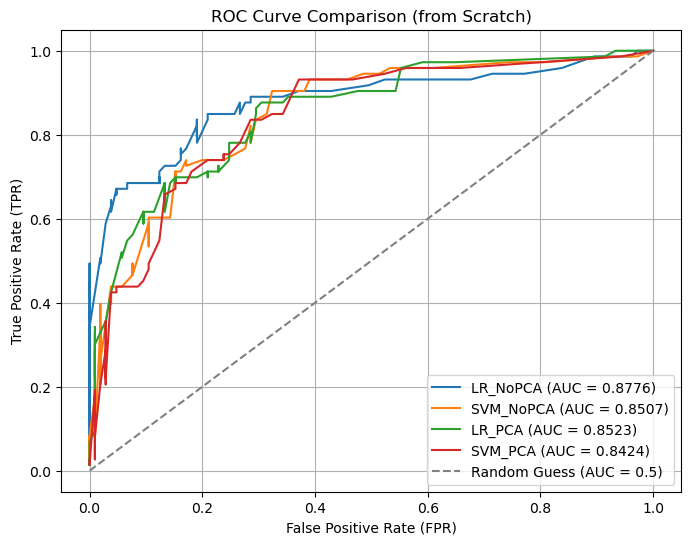

In [ ]:
# CELL 5: Final Visualizations and Summary

# --- Plotting 1: ROC Curve Comparison ---
plt.figure(figsize=(8, 6))

for name, (fpr, tpr) in roc_data.items():
    auc_val = results[name + '_AUC']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_val:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess (AUC = 0.5)')
plt.title('ROC Curve Comparison (from Scratch)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Plotting 2: Accuracy Comparison ---
accuracy_results = {k: v for k, v in results.items() if not k.endswith('_AUC')}
labels = accuracy_results.keys()
accuracies = accuracy_results.values()

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color=['skyblue', 'lightcoral', 'skyblue', 'lightcoral'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom')

plt.ylim(0.0, 1.0)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of SVM and Logistic Regression\n(from Scratch)')
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

# --- Final Summary Table ---
results_df = pd.DataFrame([
    {'Model': 'LR_NoPCA', 'Accuracy': results['LR_NoPCA'], 'AUC': results['LR_NoPCA_AUC']},
    {'Model': 'SVM_NoPCA', 'Accuracy': results['SVM_NoPCA'], 'AUC': results['SVM_NoPCA_AUC']},
    {'Model': 'LR_PCA', 'Accuracy': results['LR_PCA'], 'AUC': results['LR_PCA_AUC']},
    {'Model': 'SVM_PCA', 'Accuracy': results['SVM_PCA'], 'AUC': results['SVM_PCA_AUC']},
])

print("\n--- Final Model Comparison Results ---")
print(results_df)